In [1]:
# NUMPY
import numpy as np

# MATPLOTLIB
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# POT
import ot
from ot import sinkhorn, emd
# from ot.bregman import sinkhorn, greenkhorn

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 

# GREENKHORN 
# from greenkhorn.sinkhorn import sinkhorn as sinkhgreen
# SCREENKHORN
from screenkhorn.screenkhorn import Screenkhorn
# np.random.seed(3946)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data generation

In [2]:
n_1 = 1000# nb samples
n_2 = 1000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.01

In [3]:
# EMD = emd(a, b, M, numItermax=100000, log=True)
# EMD

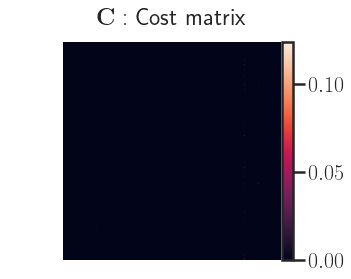

In [4]:
cb_padding = 0.005
fig, ax = plt.subplots(ncols=1) #, figsize=(20,20))
I1 = ax.matshow(np.exp(-M.T/reg))
ax.set_title(r'$\mathbf{C}:$ Cost matrix ')
ax.axis('off')
fig.colorbar(I1, ax=ax, pad=cb_padding, orientation="vertical")
ax.label_outer()

## Greenkhorn from POT

In [5]:
# P_green = greenkhorn(a, b, M, reg, numItermax=1000, stopThr=1e-09, verbose=False, log=False)
# P_green

## Greenkhorn from Altshuler et al

In [6]:
# P_green, _, _ = sinkhgreen(M, a, b, False, M, max_iter=1000)
# (A, r, c, compute_otvals, C, max_iter):
# P_green

## Sinkhorn's algorithm from POT

In [7]:
P_sink = sinkhorn(a, b, M, reg, log=True)

In [8]:
# Print P^star, u_sink = e^{u^star}, v_sink = e^{v^star}
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']

In [9]:
exp_u_star.shape, P_star.shape, exp_v_star.shape

((1000,), (1000, 1000), (1000,))

## Direct Implementation of Sinkhorn

In [10]:
def sinkhorn_direct(a, b, M, reg, max_iter=5000):
    (n, m) = M.shape
    u_k = np.ones(n)
    v_k = np.ones(m)
    max_iter = 1001
    K = np.exp(-M/reg)
    for k in range(max_iter):
        u_k = np.divide(a, K @ v_k)
        v_k = np.divide(b, K.T @ u_k)
        P_k = (np.diag(u_k) @ K) @ np.diag(v_k) # .reshape(-1)
        sinkhorn_distance = np.sqrt(sum(sum(np.multiply(P_k, K))))
        return P_k, u_k, v_k, sinkhorn_distance

In [11]:
# P_direct = sinkhorn_direct(mu, nu, C, eta, max_iter=5001)
P_direct, u_direct, v_direct, sinkhorn_distance = sinkhorn_direct(a, b, M, reg, max_iter=1000)

In [12]:
u_direct.shape, P_direct.shape, v_direct.shape, sinkhorn_distance

((1000,), (1000, 1000), (1000,), 0.01099785676431127)

## Some plots to get the difference between $P^\star$ from the POT and direct implementation

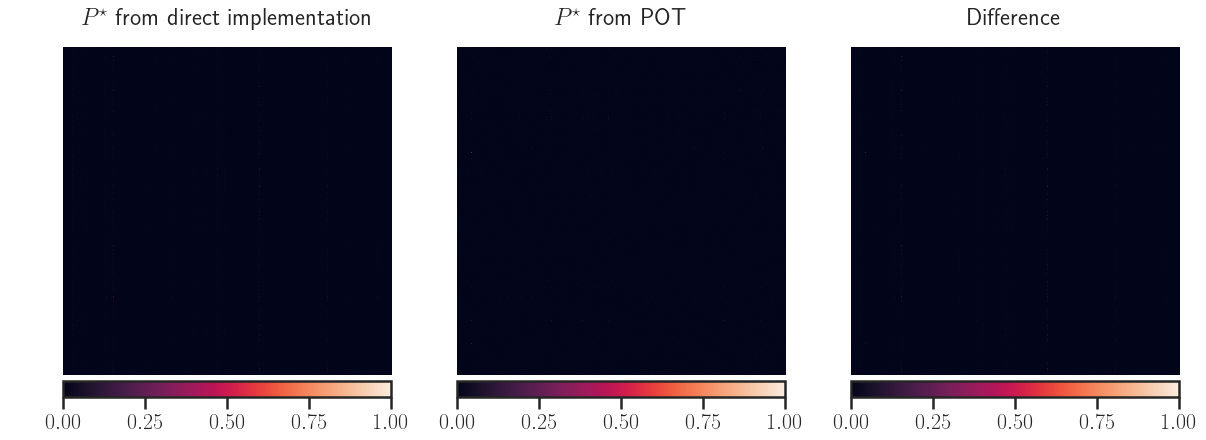

In [13]:
cb_padding = 0.005
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
I1 = ax1.matshow(np.divide(P_direct.T, P_direct.max()))
ax1.set_title(r'$P^\star$ from direct implementation')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(np.divide(P_star.T, P_star.max()))
ax2.set_title(r'$P^\star$ from POT');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
I3 = ax3.matshow(np.divide(np.abs(P_direct.T - P_star.T) , np.abs(P_direct.T - P_star.T).max()))
ax3.set_title('Difference');
# ax3.label_outer()
ax3.axis('off');
fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)

## Screenkhorn

In [14]:
# Initialization
# epsilon = 1e-19
epsilon = 0.
screenkhorn = Screenkhorn(a, b, M, reg, epsilon)

### Plots of $e^{u^\star}$ and $e^{v^\star}$ from POT

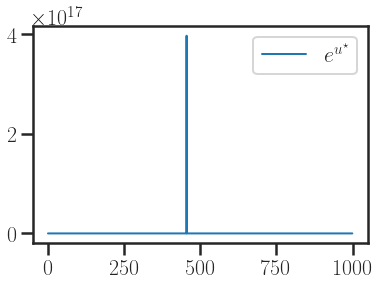

In [15]:
#plt.yscale('log')
plt.plot(exp_u_star, linewidth=2, label=r'$e^{u^\star}$');
plt.legend();

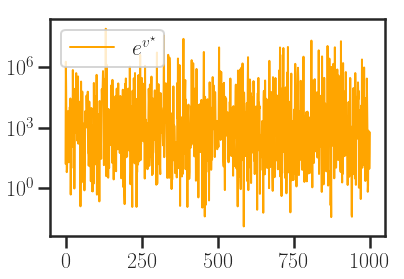

In [16]:
plt.yscale('log')
plt.plot(exp_v_star, linewidth=2, color='orange', label=r'$e^{v^\star}$');
plt.legend();

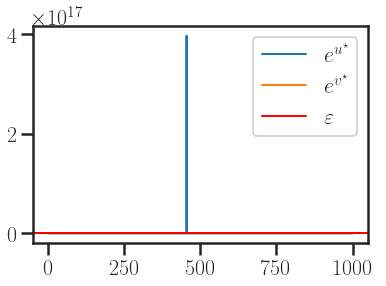

In [17]:
# plt.yscale('log')
plt.plot(exp_u_star, linewidth=2, label=r'$e^{u^\star}$')
plt.plot(exp_v_star, linewidth=2, label=r'$e^{v^\star}$') 
plt.axhline(y= epsilon, linewidth=2, color='r', label=r'$\varepsilon$')
plt.legend();

### $\ell_2$-norm of $e^{u^\star}$ and $e^{v^\star}$

In [18]:
norm2exp_u_star = np.linalg.norm(exp_u_star)
norm2exp_v_star  = np.linalg.norm(exp_v_star)
norm2exp_u_star, "---------", norm2exp_v_star , norm2exp_u_star / norm2exp_v_star

(3.9739227277479123e+17, '---------', 100587931.77180251, 3950695334.6682777)

### Plots of $u^\star$ and $v^\star$

In [19]:
u_star = np.log(exp_u_star)
v_star = np.log(exp_v_star)

# plt.plot(u_star , linewidth=2, label=r'${u^\star}$')
# plt.plot(v_star , linewidth=2, label=r'${v^\star}$') 
# plt.axhline(y =np.log(epsilon), linewidth=2, color='r', label=r'$\log(\varepsilon)$')
# plt.legend(loc='best');

### Choosing of the intervals $I_u$ and $J_u$

In [20]:
I = np.where(exp_u_star >= epsilon)[0].tolist()
#Ic = np.where(exp_v_star < epsilon)[0].tolist()
#len(I), len(Ic)
#Ic

In [21]:
J = np.where(exp_v_star >= epsilon)[0].tolist()
#Jc = np.where(exp_v_star < epsilon)[0].tolist()
#len(J), len(Jc)

In [22]:
# Objective function
# obj = screenkhorn.objective(u_star, v_star, I, J)
# obj

In [23]:
# grad = screenkhorn.grad_objective(u_star, v_star, I, J)
# grad[0], grad[1]

### `screenkhorn = Screening Sinkhorn` potentials vectors by Projected Gradient Descent algorithm

In [24]:
proj_grad = screenkhorn.projected_grad(I, J, max_iter=1000, tol=1e-10, verbose=False)
# proj_grad

/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:231: RuntimeWarning: divide by zero encountered in log
  u_sc[Ic] = np.array([np.log(self.epsilon)] * len(Ic))
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:232: RuntimeWarning: divide by zero encountered in log
  v_sc[Jc] = np.array([np.log(self.epsilon)] * len(Jc))
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:82: RuntimeWarning: divide by zero encountered in log
  u_param_Ic = np.array([np.log(self.epsilon)] * card_Ic)
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:83: RuntimeWarning: divide by zero encountered in log
  v_param_Jc =  np.array([np.log(self.epsilon)] * card_Jc)
100%|██████████| 1000/1000 [00:51<00:00, 19.30it/s]

counting cp:  657


### Curve of the objective function

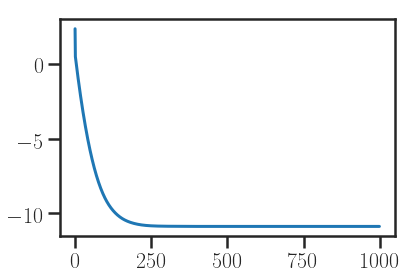

In [25]:
obj = list(proj_grad[2].values())

obj = np.asarray(obj)
obj = obj.T
obj.shape = (len(obj,))
plt.plot(obj);

In [26]:
obj[-1]

-10.91454005927573

### Sort of the solution by `screenkhorn` $e^{u_\text{sc}}$

In [27]:
# proj_grad[2]

In [28]:
v_star.shape, proj_grad[0][:5]

((1000,),
 array([ 6.69921308,  4.92162403, -1.1362666 ,  8.01101415, 11.8333905 ]))

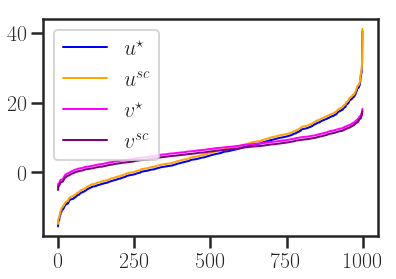

In [29]:
plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
plt.plot(np.sort(proj_grad[0]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
plt.plot(np.sort(proj_grad[1]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
plt.legend(loc='best');

In [30]:
# plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
# plt.plot(np.sort(proj_grad[0]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
# plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
# plt.plot(np.sort(proj_grad[1]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
# plt.legend();

## Verification of $$e^{{u_\text{sc}}_{I_u}} = \log(\varepsilon)$$

In [31]:
# x[Ic] == np.log(epsilon)

## Estimated marginals 

$$ P^{sc} = \Delta(e^{u_{sc}}) K \Delta(e^{v_{sc}})$$

In [32]:
# e^{u_{\text{sc}} K e^{v_{\text{sc}}$$
## Marginals 
K = np.exp(- screenkhorn.M / screenkhorn.reg)
u_sc = proj_grad[0]
u_sc.shape=(n_1,)
v_sc = proj_grad[1]
v_sc.shape=(n_2,)
P_sc = np.diag(np.exp(u_sc)) @ K @ np.diag(np.exp(v_sc))
# P_star[:20], "\n", P_sc[:20]

In [33]:
norm2u_sc = np.linalg.norm(np.exp(u_sc))
norm2v_sc = np.linalg.norm(np.exp(v_sc))

print(norm2u_sc, "\t", norm2exp_u_star)
print("\n")
print(norm2v_sc, "\t", norm2exp_v_star)

print("\n")
print(norm2u_sc / norm2v_sc, "\t", norm2exp_u_star /norm2exp_v_star)

8.199710451898588e+17 	 3.9739227277479123e+17


48814047.254102156 	 100587931.77180251


16797850031.19059 	 3950695334.6682777


### Gap between true and estimated marginals 

In [34]:
a_sc = P_sc @ np.ones(len(v_sc))
b_sc = P_sc.T @ np.ones(len(u_sc))
# print(np.abs(a - a_sc))
#plt.plot(a)
#plt.plot(np.abs(a - a_sc));
# print('-------------- Marginals giv')

print(a[:30]) 
print("\n")
print(a_sc[:30]) 
print("\n")
sum(a_sc)

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001]


[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001]




1.0

In [35]:
print(b[:30]) 
print("\n")
print(b_sc[:30]) 
print("\n")
sum(b_sc)
#b[:30] - b_sc[:30]

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001]


[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001]




0.9999999999999993

In [36]:
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

In [37]:
abs(sum(a_sc) - 1),  "\n\n", abs(sum(b_sc) - 1)

(0.0, '\n\n', 6.661338147750939e-16)

In [38]:
abs(1 - sum(b_star)), abs(1- sum(b_sc))

(8.881784197001252e-16, 6.661338147750939e-16)

In [39]:
a[:30]- a_sc[:30]

array([ 5.41797943e-12, -2.46411138e-12,  2.23322402e-12, -1.86722122e-12,
        5.70953853e-12,  1.69734279e-12, -2.82021585e-12,  5.52367375e-12,
        5.17171831e-12, -1.58195744e-12,  2.17570103e-12,  5.46349207e-12,
        3.27681198e-12, -2.44627864e-12,  5.37189867e-13, -6.39857958e-13,
       -1.66012711e-12, -1.32448219e-12,  4.34391282e-12,  3.86224689e-13,
       -1.84931367e-12,  3.95656424e-12,  2.96267741e-12, -1.79163151e-12,
        2.20467524e-12, -3.55650405e-12, -7.04298425e-12,  6.60209951e-13,
        1.97513880e-13, -1.42006155e-12])

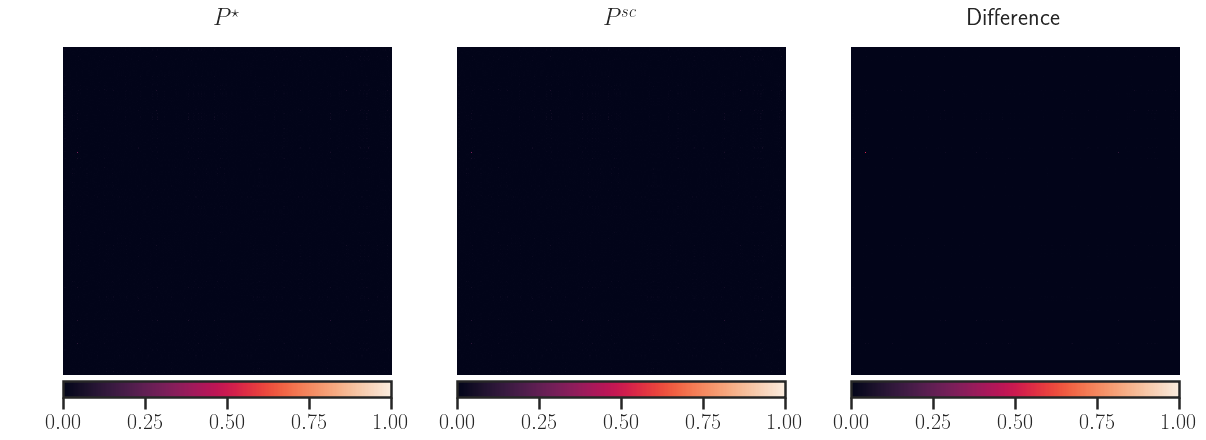

In [40]:
cb_padding = 0.005
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
I1 = ax1.matshow(np.divide(P_star.T, P_star.max()))
ax1.set_title(r'$P^\star$')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(np.divide( P_sc.T,  P_sc.T.max()))
ax2.set_title(r'$P^{sc}$');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
I3 = ax3.matshow(np.divide(np.abs(P_sc.T - P_star.T) , np.abs(P_sc.T - P_star.T).max()))
ax3.set_title('Difference');
# ax3.label_outer()
ax3.axis('off');
fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)

In [41]:
P_sc[:5, :5]

array([[4.20316072e-06, 8.37112259e-09, 6.79668645e-10, 1.11465332e-06,
        2.06730343e-06],
       [2.33631095e-08, 1.07526713e-06, 1.92658055e-06, 3.45925689e-07,
        9.64517290e-08],
       [7.20958029e-07, 5.96059444e-07, 9.86067297e-08, 2.02027458e-06,
        7.84939775e-07],
       [5.93706160e-08, 6.23079019e-07, 1.10662659e-06, 4.97092969e-07,
        2.16285716e-07],
       [6.02102408e-06, 2.35141961e-09, 2.40087542e-10, 8.61819821e-07,
        2.85293892e-06]])

In [42]:
P_star[:5, :5]

array([[4.20278703e-06, 8.38432926e-09, 6.81128374e-10, 1.11531306e-06,
        2.06786443e-06],
       [2.33234523e-08, 1.07523105e-06, 1.92761240e-06, 3.45573628e-07,
        9.63227023e-08],
       [7.20429551e-07, 5.96615244e-07, 9.87548518e-08, 2.02016816e-06,
        7.84647006e-07],
       [5.92771334e-08, 6.23134796e-07, 1.10735556e-06, 4.96648177e-07,
        2.16022967e-07],
       [6.02083939e-06, 2.35526648e-09, 2.40617191e-10, 8.62380132e-07,
        2.85387930e-06]])

In [43]:
np.sqrt(sum(sum(np.multiply(P_star, M)))) - u_star @ a - v_star @ b

-11.413298541828276

In [44]:
np.sqrt(sum(sum(np.multiply(P_sc, M)))) - u_sc @ a - v_sc @ b

-11.413298705930575

In [45]:
np.sqrt(sum(sum(np.multiply(P_star, M)))) - np.sqrt(sum(sum(np.multiply(P_sc, M))))

2.095167428439737e-08

In [46]:
np.sqrt(sum(sum(np.multiply(P_star, M)))) - u_star @ a - v_star @ b\
- np.sqrt(sum(sum(np.multiply(P_sc, M)))) + u_sc @ a + v_sc @ b

1.6410229797259035e-07